# Strategy
#### Timeseries required (example)
1. Generate initial Hurst exp (H_0) using one month worth of 1hr data (672 datapoints). Use entire november data to generate H_0
2. Then, generate Hurst exp time series from H_0 for the month of Dec. This will result in 672 1hr data points of Hurst exp for Dec.
3. We need to feed in 3 times series into the back tester (all in Dec):
    - Price series of underlying 
    - Price series of perp swap
    - Hurst exp
4. Create strategy for mean reversion:
    - start trading only when hurst is below 0.5 (mean reverting)
    - incorporate bollinger bands to make hurst strat more robust

When price is inside Bollinger Band (BB):
- H > 0.5 -> hedge by long/short perp in opposite direction of underlying
- if rebound from upper BB + H < 0.5 -> short underlying
- if rebound from lower BB + H < 0.5 -> long underlying

When price is above Bollinger band:
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> short underlying

When price is below Bollinger band
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> long underlying

In general, when price is outside BB, take action only when H < 0.5 (mean reverting). When inside BB, hedge with perp in opposite direction only when H > 0.5 (trending)

Timeframe to generate H: 1 week

- test multiple timeframes and see how the strategies work in different timeframes

- Entry: Bollinger band upper and bottom limit
- We use the timestamp's volume to compare with its rolling volume for a week. If the volume > the rolling volume, more market movement to be anticipated.

#### Relevant links
- Detrended Fluctuation Analysis (DFA): https://raposa.trade/blog/find-your-best-market-to-trade-with-the-hurst-exponent/

24-Oct
- Trending indicator: (StochRSI)
    - to tell us if the prices are trending and we are on the opposite signal (losing money)
    - if trending up or down, the signal reflected has to be correct
    - e.g. bullish -> long (not short)
    - bearish -> short
- Analysis on perp
    - if the trending indicator alerts us on the trends but we are still on the opposite signal
    - that will be the point that we start using the perp to hedge
    - when we use the perp to hedge -> how can be combine it to show the returns or pnl?
- General time series analysis (data vis) (done)
    - correlation study (plotting)
    - rolling correlation (weekly, monthly, quarterly)
    - generalised plots of all normalised coins with their perp
    - churn out the plots and save to separate file

25-Oct
- Important: all t/s data have missing data 
- always resample the data to 'H'
- Trending indicator (stochRSI)
    - how can we further finetune
    - for hurst we need to further analyse (using btrader hurst, or we define the lags function (new))
- (Naive Strategy) Hurst: use the new lags function find hurst:
    - use hurst condition for either long or short
    - calculate sharpe ratio
- (Think as we go) Pairs-Analysis with Hurst exponent:
    - if correlation dips, we can run long-short on opposing coins
- Try out Pairs-trading strategy (based on correlation plot and hurst)
- Sharpe Ratio for current naive strategy

## Imports and Wrangle

In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme()
import backtrader as bt
import backtrader.plot
from backtrader.feeds import PandasData
import warnings
warnings.filterwarnings('ignore')

### Fetch Data from Pickle files

In [38]:
# read spot data
df_spot = pd.read_pickle('../data/overall.pkl')

# read perp data
df_perp = pd.read_pickle('../data/perp_overall.pkl')

print(df_spot.ticker.unique(), df_perp.ticker.unique(), df_spot.columns)

['BINANCE_SPOT_BTC_USDT' 'BINANCE_SPOT_ETH_USDT' 'BINANCE_SPOT_BNB_USDT'
 'BINANCE_SPOT_ADA_USDT' 'BINANCE_SPOT_XRP_USDT' 'BINANCE_SPOT_MATIC_USDT'
 'BINANCE_SPOT_SOL_USDT' 'BINANCE_SPOT_UNI_USDT' 'BINANCE_SPOT_AVAX_USDT'] ['BINANCEFTS_PERP_BTC_USDT' 'BINANCEFTS_PERP_ADA_USDT'
 'BINANCEFTS_PERP_ETH_USDT' 'BINANCEFTS_PERP_XRP_USDT'
 'BINANCEFTS_PERP_DOGE_USDT' 'BINANCEFTS_PERP_SOL_USDT'
 'BINANCEFTS_PERP_UNI_USDT' 'BINANCEFTS_PERP_AVAX_USDT'
 'BINANCEFTS_PERP_MATIC_USDT' 'BINANCEFTS_PERP_BNB_USDT'] Index(['time_period_start', 'time_period_end', 'time_open', 'time_close',
       'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded',
       'trades_count', 'ticker'],
      dtype='object')


In [45]:
# overall class methods to wrangle the data
class Wrangle:

    one_week = 168
    one_month = 672
    per_day = int(24)

    @classmethod
    def get_hurst_periods(cls):
        return [days * cls.per_day for days in [7, 14, 30, 90, 180, 270]]

    # hurst exponent through rescaled range
    @classmethod
    def hurst_rs(cls, ts):
        ts = np.array(ts)
        # N is use for storge the length sequence
        total_len, rescaled_range, ts_len = [], [], len(ts)
        while True:
            total_len.append(ts_len)
            # calculate mean 
            m = np.mean(ts)
            # calculate mean deviation
            mean_dev = ts - m
            # Construct cumulative deviation sequence
            cumulative_dvi = np.cumsum(mean_dev)
            # Calculate max_diff
            max_diff = max(cumulative_dvi) - min(cumulative_dvi)
            # Calculate the unbiased standard deviation of this sequence
            unbiased_std_dvi = np.std(ts)
            # Calculate the rescaled range of this sequence under n length
            rescaled_range.append(max_diff / unbiased_std_dvi)
            # While n < 4 then break
            if ts_len < 4:
                break
            # Rebuild this sequence by half length
            ts, ts_len = cls.half_series(ts, ts_len)
            # Get Hurst-index by fit log(RS)~log(n)
            hurst_slope = np.polyfit(np.log10(total_len), np.log10(rescaled_range), 1)[0]
        return hurst_slope

    # helper function to break the t/s into smaller portions
    @staticmethod
    def half_series(s, n):
    # ''' if length(X) is odd: X <- {(X1 + X2) / 2, ..., (Xn-2 + Xn-1) / 2, Xn} n <- (n - 1) / 2 else: X <- {(X1 + X2) / 2, ..., (Xn-1 + Xn) / 2} n <- n / 2 return X, n '''
        x = []
        for i in range(0, len(s) - 1, 2):
            x.append((s[i] + s[i + 1]) / 2)
        # if length(s) is odd
            if len(s) % 2 != 0:
                x.append(s[-1])
                n = (n - 1) // 2
            else:
                n = n // 2
        return [np.array(x), n]

    @staticmethod
    def __z_score(ts):
        return (ts[-1] - ts[:-1].mean()) / ts[:-1].std()

    ## choose the ticker inside the dataframe
    ### **** missing data is present in coinAPI pull -> forward fill 'H' frequency always when using the data
    @classmethod
    def get_backtest_ticker_df(cls, df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, resample_period=None, with_returns=True, with_z_score=True, rolling_window=168) -> pd.DataFrame:
        data = df.loc[(df['ticker'] == ticker) & (df['time_period_start'] >= start_dt) & (df['time_period_start'] <= end_dt)]
        data = data[['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']]
        data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.set_index('DateTime', inplace=True)

        # portion to resample
        if resample_period is not None:
            data = data.resample(resample_period).agg(
                {
                "Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last",
                "Volume": "mean",
                    }).fillna(method='ffill')

        if with_returns:
            data['ret'] = data['Close'].pct_change()
            data = data.iloc[1:, :]
            if with_z_score:
                data['z_score'] = data['ret'].rolling(rolling_window).apply(cls.__z_score)
        data.ffill(True, inplace=True)

        return data

    # get the dataframe with hurst for a singular ticker
    @classmethod
    def get_backtest_ticker_with_hurst_df(cls, df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, rolling_window: int, resample_period=None, with_returns=True, with_z_score=True) -> pd.DataFrame:
        df = cls.get_backtest_ticker_df(df, ticker, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window)
        df['hurst'] = df['Close'].rolling(rolling_window).apply(cls.hurst_rs)

        return df.iloc[rolling_window - 1:, :]

    # get data for all the tickers and its perp and store into a dict
    @classmethod
    def get_all_backtest_ticker_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, resample_period=None, with_returns=True, with_z_score=True, rolling_window=168) -> dict:
        backtest_dict = {spot_ticker.split('_')[2]: {
            'spot': cls.get_backtest_ticker_df(df_spot, spot_ticker, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window),
            'perp': cls.get_backtest_ticker_df(df_perp, perp_ticker, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window)
        } for spot_ticker, perp_ticker in zip(df_spot.ticker.unique(), df_perp.ticker.unique())}
        
        return backtest_dict
    
    # get data for all the tickers and its perp and calculate the hurst before storing into a dict
    @classmethod
    def get_all_backtest_ticker_with_hurst_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, rolling_window: int, resample_period=None, with_returns=True, with_z_score=True) -> dict:
        backtest_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window)
        ticker_list = list(backtest_dict.keys())
        for ticker in ticker_list:
            df = backtest_dict[ticker]['spot']
            df['hurst'] = df['Close'].rolling(rolling_window).apply(cls.hurst_rs)
            backtest_dict[ticker]['spot'] = df.iloc[rolling_window - 1:, :]

        return backtest_dict

    # plot correlation
    @classmethod
    def plot_corr_with_BTC(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, rolling_window: int, resample_period=None):
        coins_data_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, None, None)

        coins_corr = []
        for ticker in [n for n in coins_data_dict.keys() if n != 'BTC']:
            series = coins_data_dict['BTC']['spot']['Close'].rolling(rolling_window).corr(coins_data_dict[ticker]['spot']['Close'])
            series = series.rename(ticker)
            coins_corr.append(series)

        fig, axes = plt.subplots(2, 4, figsize=(25,10))
        plt.subplots_adjust(hspace=0.45, wspace=0.35)
        for series, ax in zip(coins_corr, axes.ravel()):
            series.plot(ax=ax)
            ax.set_title(f'{series.name} correlation with BTC')

    # plot timeseries
    @classmethod
    def plot_all_series(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, column_name: str, resample_period=None, with_returns=False, with_z_score=False):
        coins_data_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, with_returns, with_z_score)

        if column_name not in coins_data_dict['BTC']['spot'].columns:
            raise Exception('{} is not in DataFrame'.format(column_name))
        
        coins_data_list = []
        for ticker in coins_data_dict.keys():
            series = coins_data_dict[ticker]['spot'][column_name]
            series = series.rename(ticker)
            coins_data_list.append(series)
            
        fig, axes = plt.subplots(3, 3, figsize=(25,10))
        plt.subplots_adjust(hspace=0.7)
        for series, ax in zip(coins_data_list, axes.ravel()):
            series.plot(ax=ax)
            ax.set_title(f'{series.name} {column_name} timeseries')

## BackTrader Cerebro for btc-usdt

In [40]:
# https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed/
### define cerebro parameters here
class PandasData(bt.feeds.PandasData):
    lines = ('ret', 'hurst', 'z_score',)
    params = (
        ('ret', 'ret'),
        ('hurst', 'hurst'),
        ('z_score', 'z_score')
    )
    datafields = bt.feeds.PandasData.datafields + (['ret', 'hurst', 'z_score'])

# add hurst data
class HurstExp(bt.Indicator):
    lines = ('hurst',)
    def __init__(self):
        self.lines.hurst = self.data.hurst

# add zscore data
class Zscore(bt.Indicator):
    lines = ('z_score', )
    def __init__(self):
        self.lines.z_score = self.data.z_score

# add ret data
class Ret(bt.Indicator):
    lines = ('ret',)
    def __init__(self):
        self.lines.ret = self.data.ret
        
class StochRSI(bt.Indicator):
    lines = ('stochrsi',)
    params = dict(
        period=672,  # to apply to RSI
        pperiod=None,  # if passed apply to HighestN/LowestN, else "period"
    )

    def __init__(self):
        rsi = bt.ind.RSI(self.data, period=self.p.period)

        pperiod = self.p.pperiod or self.p.period
        maxrsi = bt.ind.Highest(rsi, period=pperiod)
        minrsi = bt.ind.Lowest(rsi, period=pperiod)

        self.l.stochrsi = (rsi - minrsi) / (maxrsi - minrsi)


# add strategies in
class St(bt.Strategy):
    def __init__(self):
        # self.sma = bt.indicators.SimpleMovingAverage(self.data)
        self.bb = bt.indicators.BollingerBands(self.data, period=168)
        self.rsi = StochRSI(self.data, period = Wrangle.one_month)
        # self.hurstbt = bt.indicators.HurstExponent(self.data, period=672*12)
        # self.hurst = HurstExp(self.data)
        # self.ret =  Ret(self.data)
        # self.zscore = Zscore(self.data)
        
    # def next(self):
    #     if self.hurst < 0.5 and self.rsi.lines[0] > 0.3 and self.rsi.lines[0] < 0.7:
    #         if self.data.close[0] > self.bb.lines.bot and self.data.close[-1] < self.bb.lines.bot:
    #             order = self.buy(price=self.data.close * 1)
    #         elif self.data.close[0] < self.bb.lines.top and self.data.close[-1] > self.bb.lines.top:
    #             order = self.sell(price=self.data.close * 1)

In [6]:
# initialise data here
cerebro_df = Wrangle.get_backtest_ticker_with_hurst_df(
    df_spot, ticker='BINANCE_SPOT_BTC_USDT', 
    start_dt='2020-11-01', end_dt='2021-11-01', 
    rolling_window=168, with_returns=True, with_z_score=True
)

In [11]:
# initialise cerebro parameters
cerebro = bt.Cerebro()
# add data
data = PandasData(dataname=cerebro_df)
cerebro.adddata(data)
# add strategy to cerebro
cerebro.addstrategy(St)
cerebro.run()

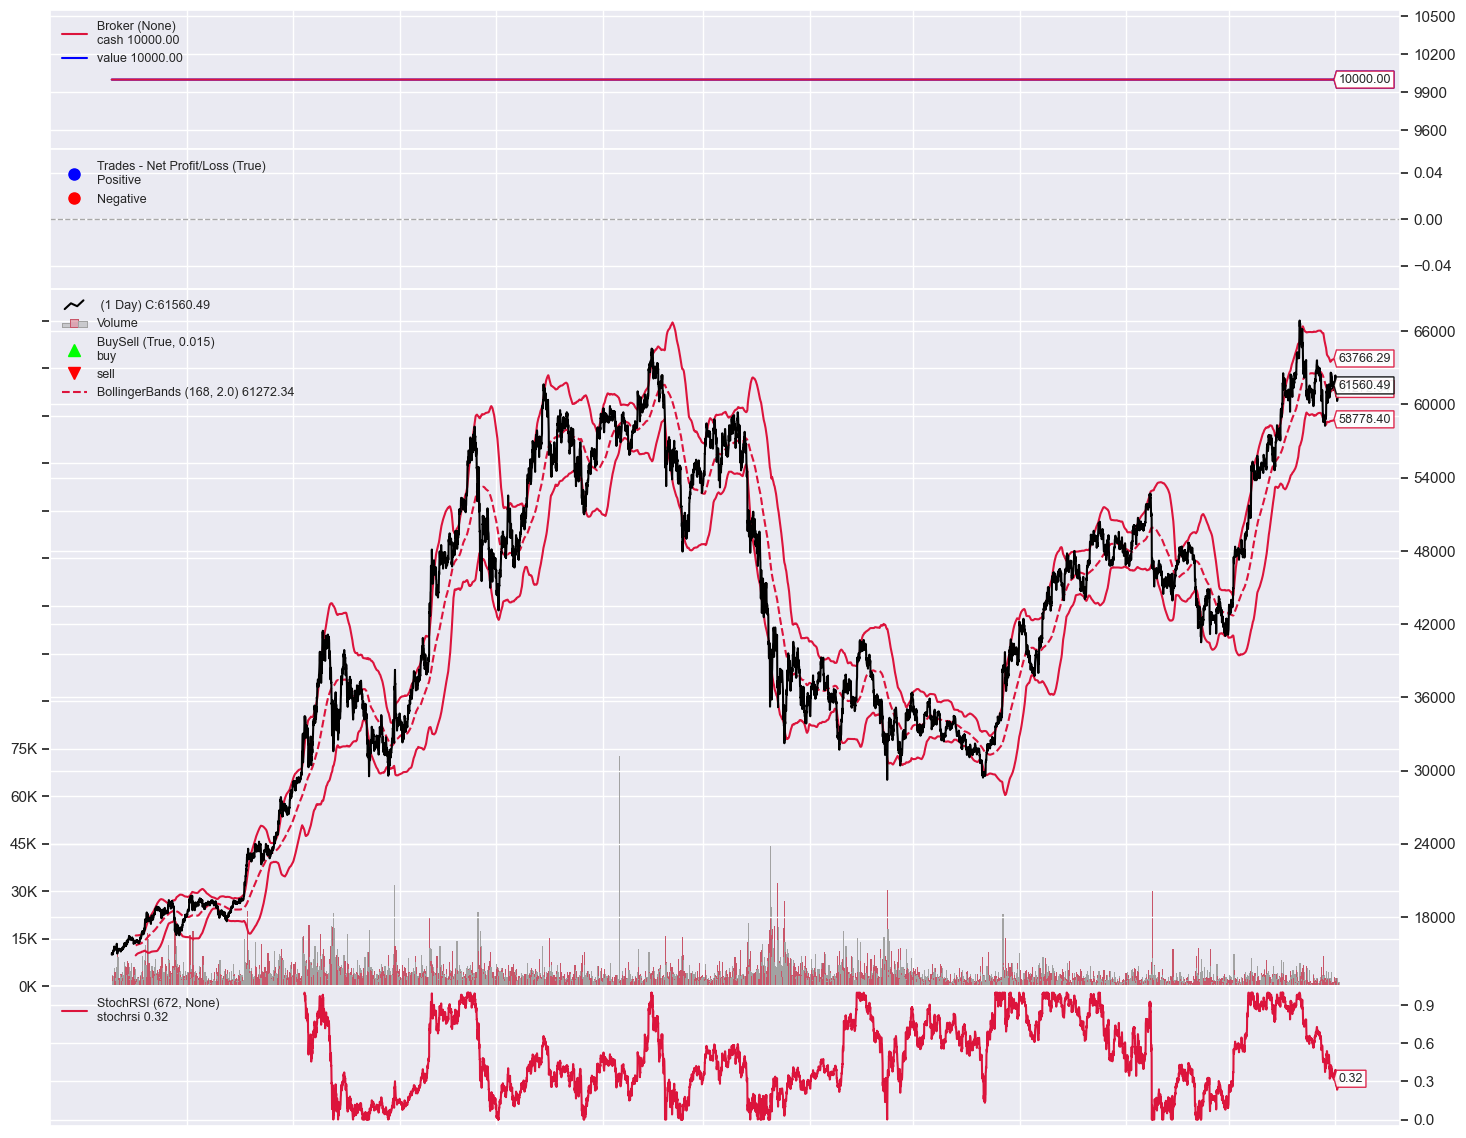

[[<Figure size 1500x1200 with 5 Axes>]]

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot=False)

In [8]:
## ****** plot must be on a separate cell to run ******
# cerebro.plot(iplot=False)

[[<Figure size 1500x1200 with 5 Axes>]]

Observations
- Naive Strategy: the strat is buying on the way down and selling on the way up
- To do: we need to eliminate these wrong entry and exit points
- *** Important Events: 11-May-2020: Btc halving

## Time series Analysis and visualisation
- Correlation: rolling correlation for all coins with BTC (main)
    - correlation plots
- perp + spot plots

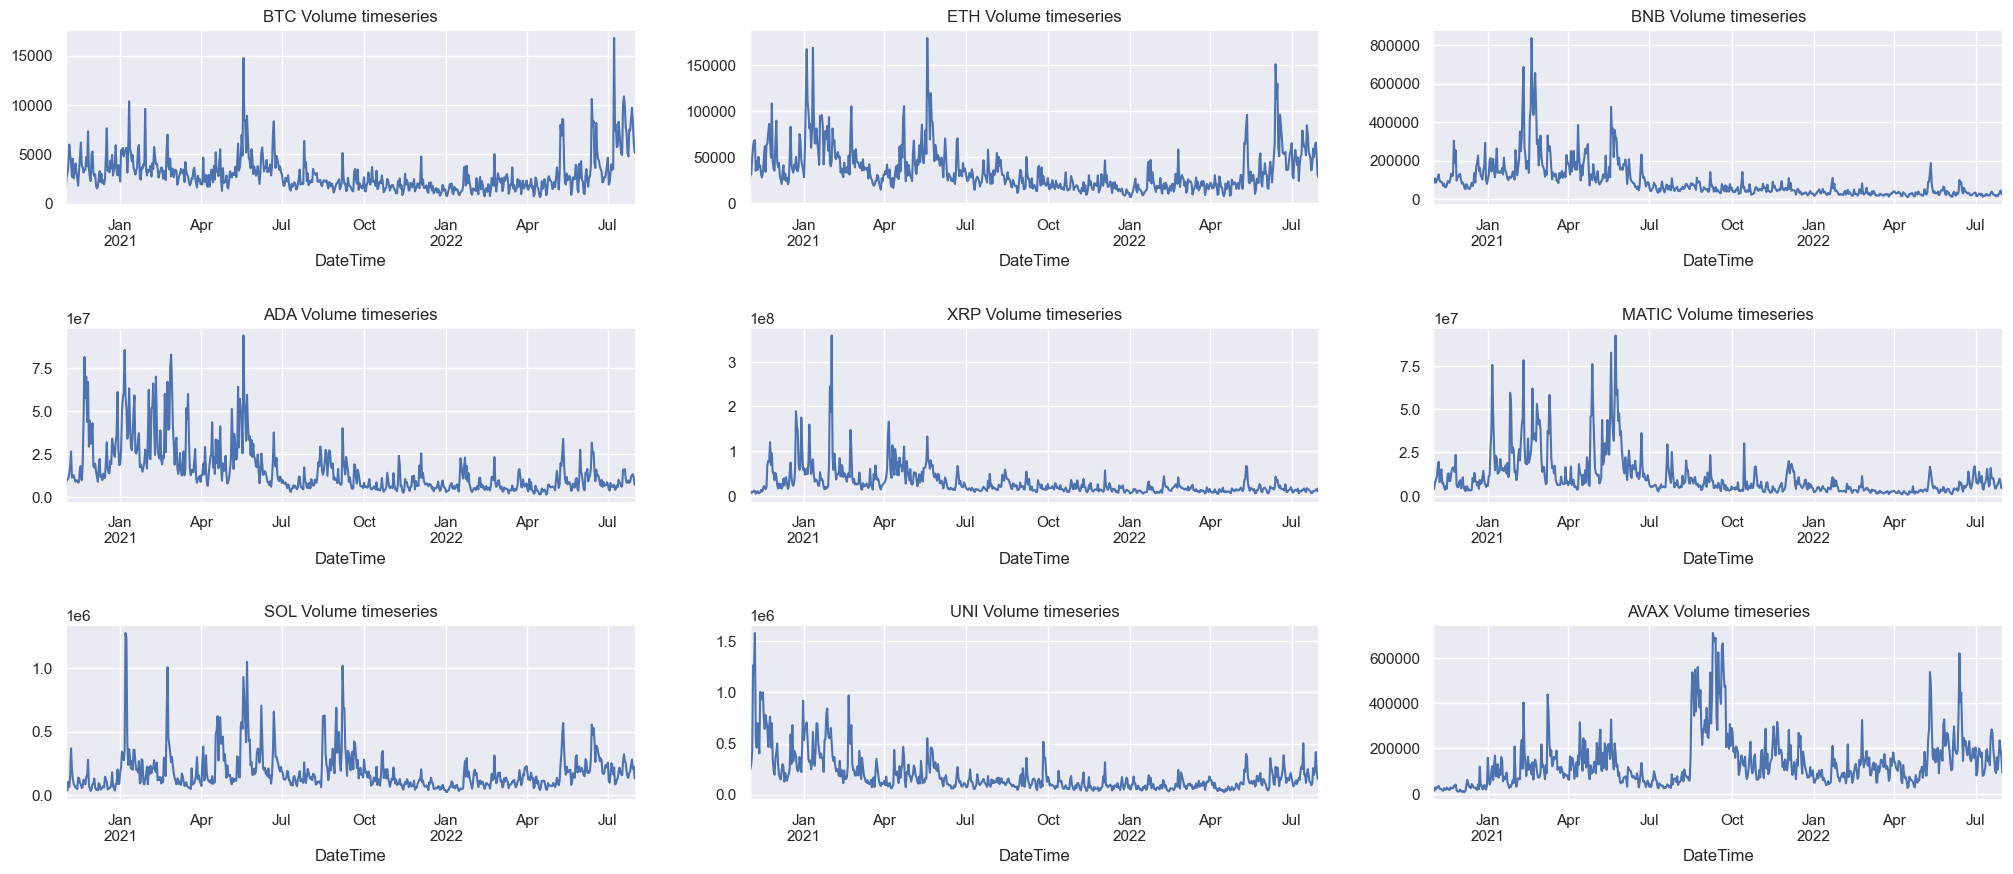

In [43]:
Wrangle.plot_all_series(df_spot, df_perp, '2020-11-01', '2022-08-01', 'Volume', resample_period='D')
plt.show()

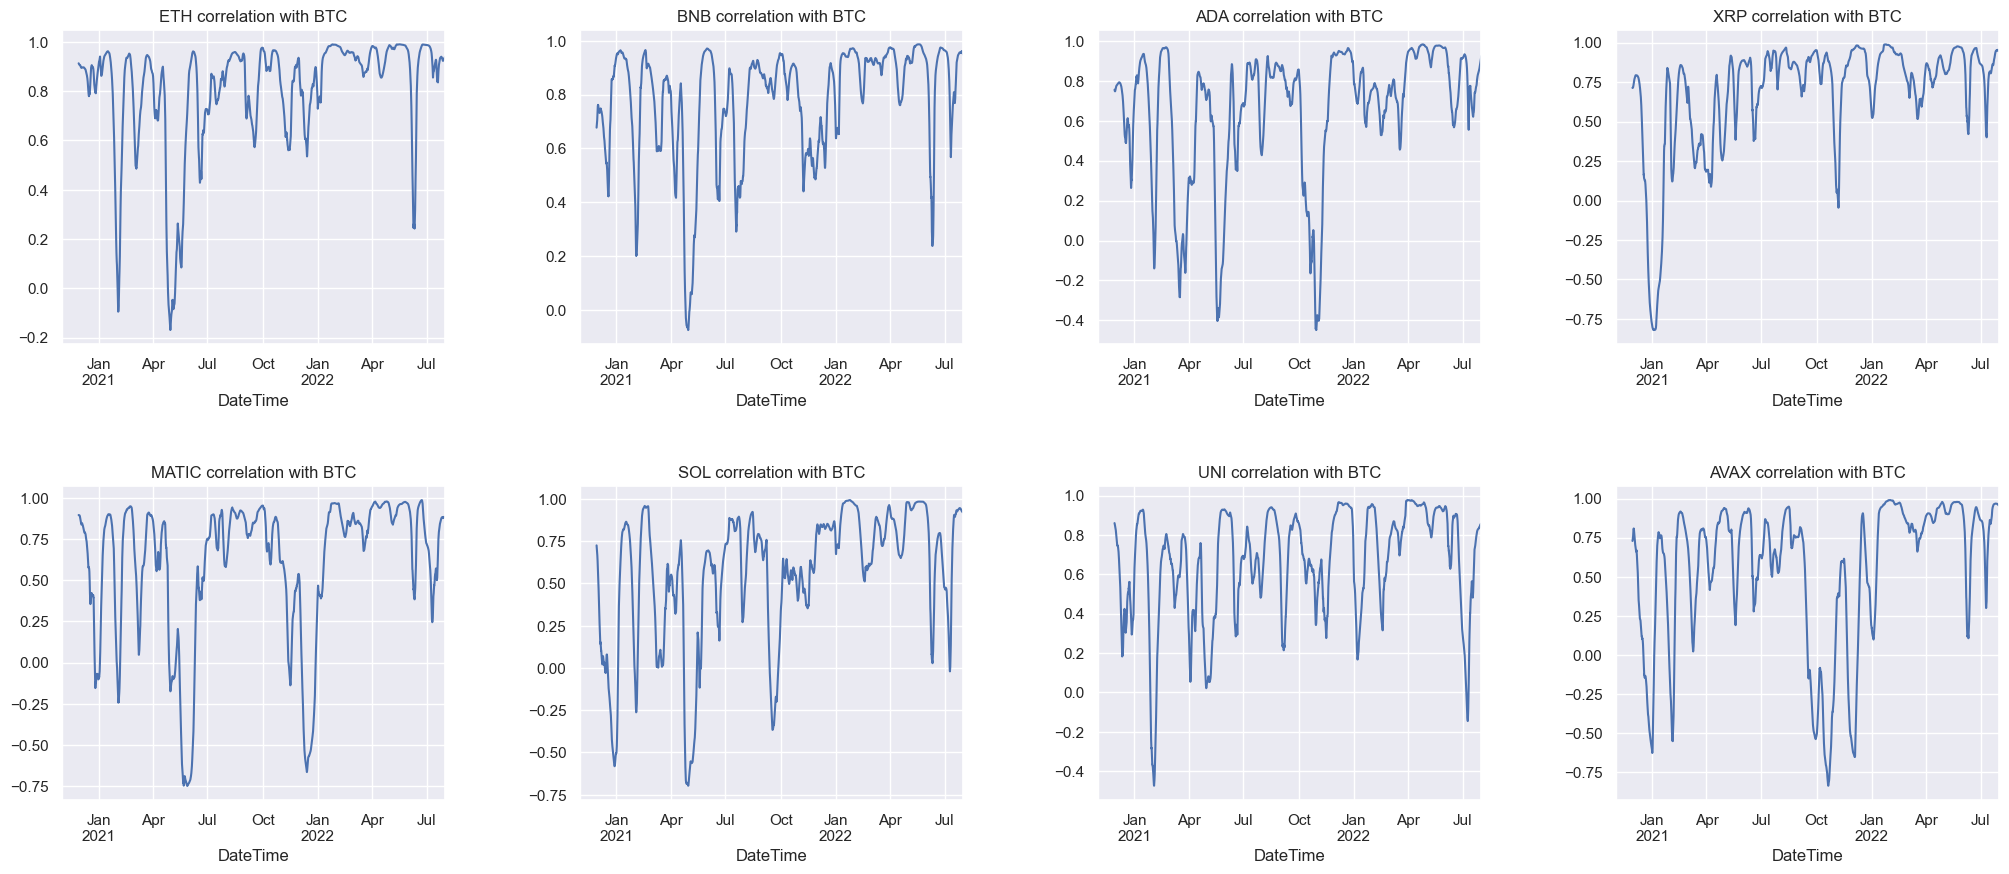

In [44]:
Wrangle.plot_corr_with_BTC(df_spot, df_perp, '2020-11-01', '2022-08-01', Wrangle.one_month, resample_period='H')